In [1]:
import cv2
import torch
import argparse
import yaml
from torchvision import transforms
import onnxruntime as ort
from PIL import Image
from insightface.app import FaceAnalysis
from omegaconf import OmegaConf
from torchvision.transforms.functional import rgb_to_grayscale
import matplotlib.pyplot as plt
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image

from src.utils.crops import *
from repos.stylematte.stylematte.models import StyleMatte
from src.utils.inference import *
from src.utils.inpainter import LamaInpainter
from src.utils.preblending import calc_pseudo_target_bg, post_inpainting
from train_aligner import AlignerModule
from train_blender import BlenderModule

import warnings
warnings.filterwarnings('ignore')

/opt/conda/envs/ghost/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/ghost/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


SWIN not found, will not be able to use SWIN models
Could not import EmoSwinModule. SWIN models will not be available.  Make sure you pull the repository with submodules to enable Swin.
Could not import EmoNetModule. EmoNet models will not be available.  Make sure you pull the repository with submodules to enable EmoNet.


/home/ubuntu/ghost-2.0/src/losses/gaze.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(False)


In [2]:
def torch2image(torch_image: torch.tensor) -> np.ndarray:
    batch = False
    
    if torch_image.dim() == 4:
        torch_image = torch_image[:8]
        batch = True
    
    device = torch_image.device
    mean = torch.tensor([0.5, 0.5, 0.5]).unsqueeze(1).unsqueeze(2).to(device)
    std = torch.tensor([0.5, 0.5, 0.5]).unsqueeze(1).unsqueeze(2).to(device)
    
    denorm_image = (std * torch_image) + mean
    
    if batch:
        denorm_image = denorm_image.permute(0, 2, 3, 1)
    else:
        denorm_image = denorm_image.permute(1, 2, 0)
    
    np_image = denorm_image.detach().cpu().numpy()
    np_image = np.clip(np_image*255., 0, 255).astype(np.uint8)
    
    if batch:
        return np.concatenate(np_image, axis=1)
    else:
        return np_image

In [3]:
with open('./configs/aligner.yaml', "r") as stream:
    cfg_a = OmegaConf.load(stream)

aligner = AlignerModule(cfg_a)
aligner.load_state_dict(torch.load('aligner_checkpoints/aligner_1020_gaze_final.ckpt'), strict=False)
aligner.eval()
aligner.cuda();

## vgg_weights_dir ./weights/


Lightning automatically upgraded your loaded checkpoint from v1.4.9 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint repos/emoca/assets/EmotionRecognition/image_based_networks/ResNet50/checkpoints/deca-epoch=01-val_loss_total/dataloader_idx_0=1.27607644.ckpt`


Looking for checkpoint in 'repos/emoca/assets/EmotionRecognition/image_based_networks/ResNet50/checkpoints'
Found 1 checkpoints
 - repos/emoca/assets/EmotionRecognition/image_based_networks/ResNet50/checkpoints/deca-epoch=01-val_loss_total/dataloader_idx_0=1.27607644.ckpt
Selecting checkpoint 'repos/emoca/assets/EmotionRecognition/image_based_networks/ResNet50/checkpoints/deca-epoch=01-val_loss_total/dataloader_idx_0=1.27607644.ckpt'
## fname:  repos/emoca/gdl_apps/EmotionRecognition/ResNet50/checkpoints/deca-epoch=01-val_loss_total/dataloader_idx_0=1.27607644.ckpt
creating the FLAME Decoder
trained model found. load ./repos/DECA/data/deca_model.tar
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/conda/envs/ghost/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


In [4]:
with open('./configs/blender.yaml', "r") as stream:
    cfg_b = OmegaConf.load(stream)

blender = BlenderModule(cfg_b)
blender.load_state_dict(torch.load('blender_checkpoints/blender_lama.ckpt', map_location='cpu')["state_dict"], strict=False,)
blender.eval()
blender.cuda()

inpainter = LamaInpainter();

## vgg_weights_dir ./weights


In [5]:
app = FaceAnalysis(providers=['CUDAExecutionProvider'], allowed_modules=['detection'])
app.prepare(ctx_id=0, det_size=(640, 640))

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/ubuntu/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/ubuntu/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/ubuntu/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/ubuntu/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /home/ubuntu/.insightface/models/buffalo_l/w600k_r50.onnx recognition
set det-size: (640, 640)


In [6]:
! pip list | grep accel

accelerate                 1.6.0


In [7]:
pipe = AutoPipelineForInpainting.from_pretrained("kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16)
pipe.enable_model_cpu_offload()

Loading pipeline components...:  67%|██████▋   | 2/3 [00:00<00:00, 16.90it/s]

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.75it/s]


## Preprocess

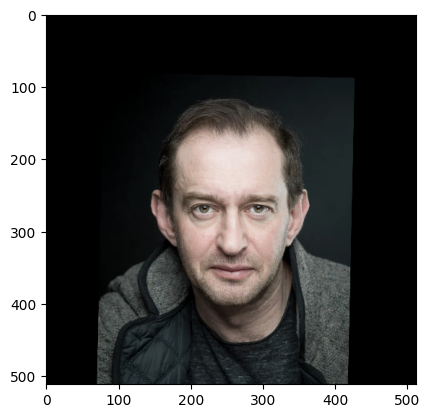

In [8]:
source_full = cv2.imread('./examples/images/hab.jpg')
dets = app.get(source_full)
kps = dets[0]['kps']
source = wide_crop_face(source_full, kps)
plt.imshow(source[:,:,::-1])

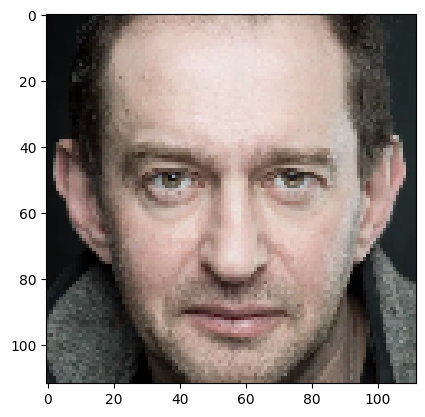

In [9]:
source_arc = norm_crop(source_full, kps)
plt.imshow(source_arc[:,:,::-1])

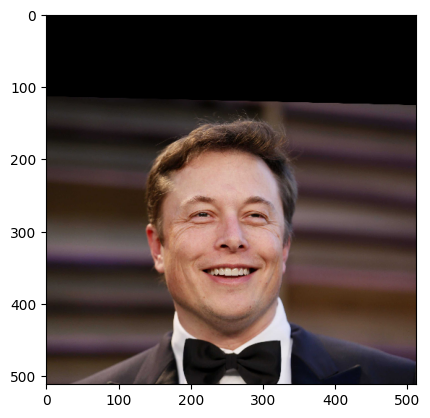

In [10]:
full_frames = cv2.imread('./examples/images/elon.jpg')
dets = app.get(full_frames)
kps = dets[0]['kps']
target = wide_crop_face(full_frames, kps, return_M=True)
target, M = target
plt.imshow(target[:,:,::-1])

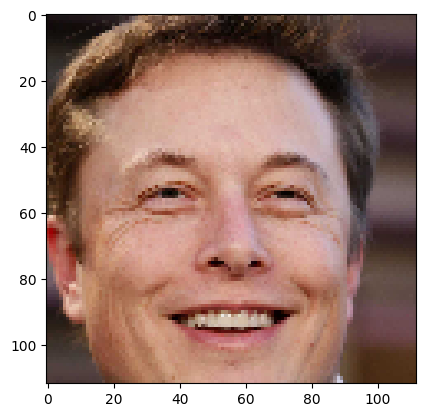

In [11]:
target_arc = norm_crop(full_frames, kps)
plt.imshow(target_arc[:,:,::-1])

## Mask

In [12]:
from repos.stylematte.stylematte.models import StyleMatte
segment_model = StyleMatte()
segment_model.load_state_dict(
    torch.load(
        './repos/stylematte/stylematte/checkpoints/stylematte_synth.pth',
        map_location='cpu'
    )
)
segment_model = segment_model.cuda()
segment_model.eval()
None

In [13]:
 def calc_mask(img):
    if isinstance(img, np.ndarray):
        img = torch.from_numpy(img).permute(2, 0, 1).cuda()
    if img.max() > 1.:
        img = img / 255.0
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    input_t = normalize(img)
    input_t = input_t.unsqueeze(0).float()
    with torch.no_grad():
        out = segment_model(input_t)
    result = out[0]

    return result[0]

In [14]:
source_mask = calc_mask(source).unsqueeze(0).unsqueeze(0).unsqueeze(0)
target_mask = calc_mask(target).unsqueeze(0).unsqueeze(0)

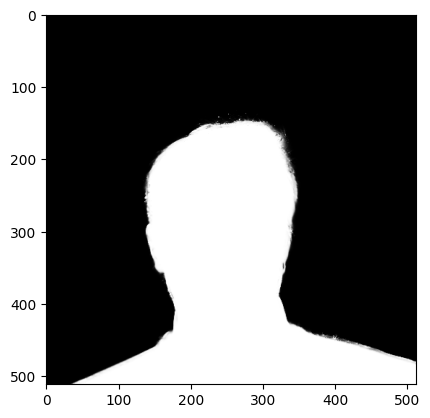

In [15]:
plt.imshow(target_mask[0].detach().cpu().permute(1, 2, 0), cmap='gray')

### Aligner

In [16]:
def normalize_and_torch(image: np.ndarray, use_cuda = True) -> torch.tensor:
    """
    Normalize image and transform to torch
    """
    if use_cuda:
        image = torch.tensor(image.copy(), dtype=torch.float32).cuda()
    else:
        image = torch.tensor(image.copy(), dtype=torch.float32)
    if image.max() > 1.:
        image = image/255.
    
    image = image.permute(2, 0, 1).unsqueeze(0)
    image = (image - 0.5) / 0.5

    return image

In [17]:
norm_source_arc = normalize_and_torch(source_arc).unsqueeze(0)
norm_target_arc = normalize_and_torch(target_arc)

norm_source = normalize_and_torch(source).unsqueeze(0)
norm_target = normalize_and_torch(target)

In [18]:
X_dict = {
        'source': {
            'face_arc': norm_source_arc,
            'face_wide': norm_source * source_mask,
            'face_wide_mask': source_mask,
        },
        'target': {
            'face_arc': norm_target_arc,
            'face_wide': norm_target * target_mask,
            'face_wide_mask': target_mask,
        }
    }

In [19]:
output = aligner(X_dict)

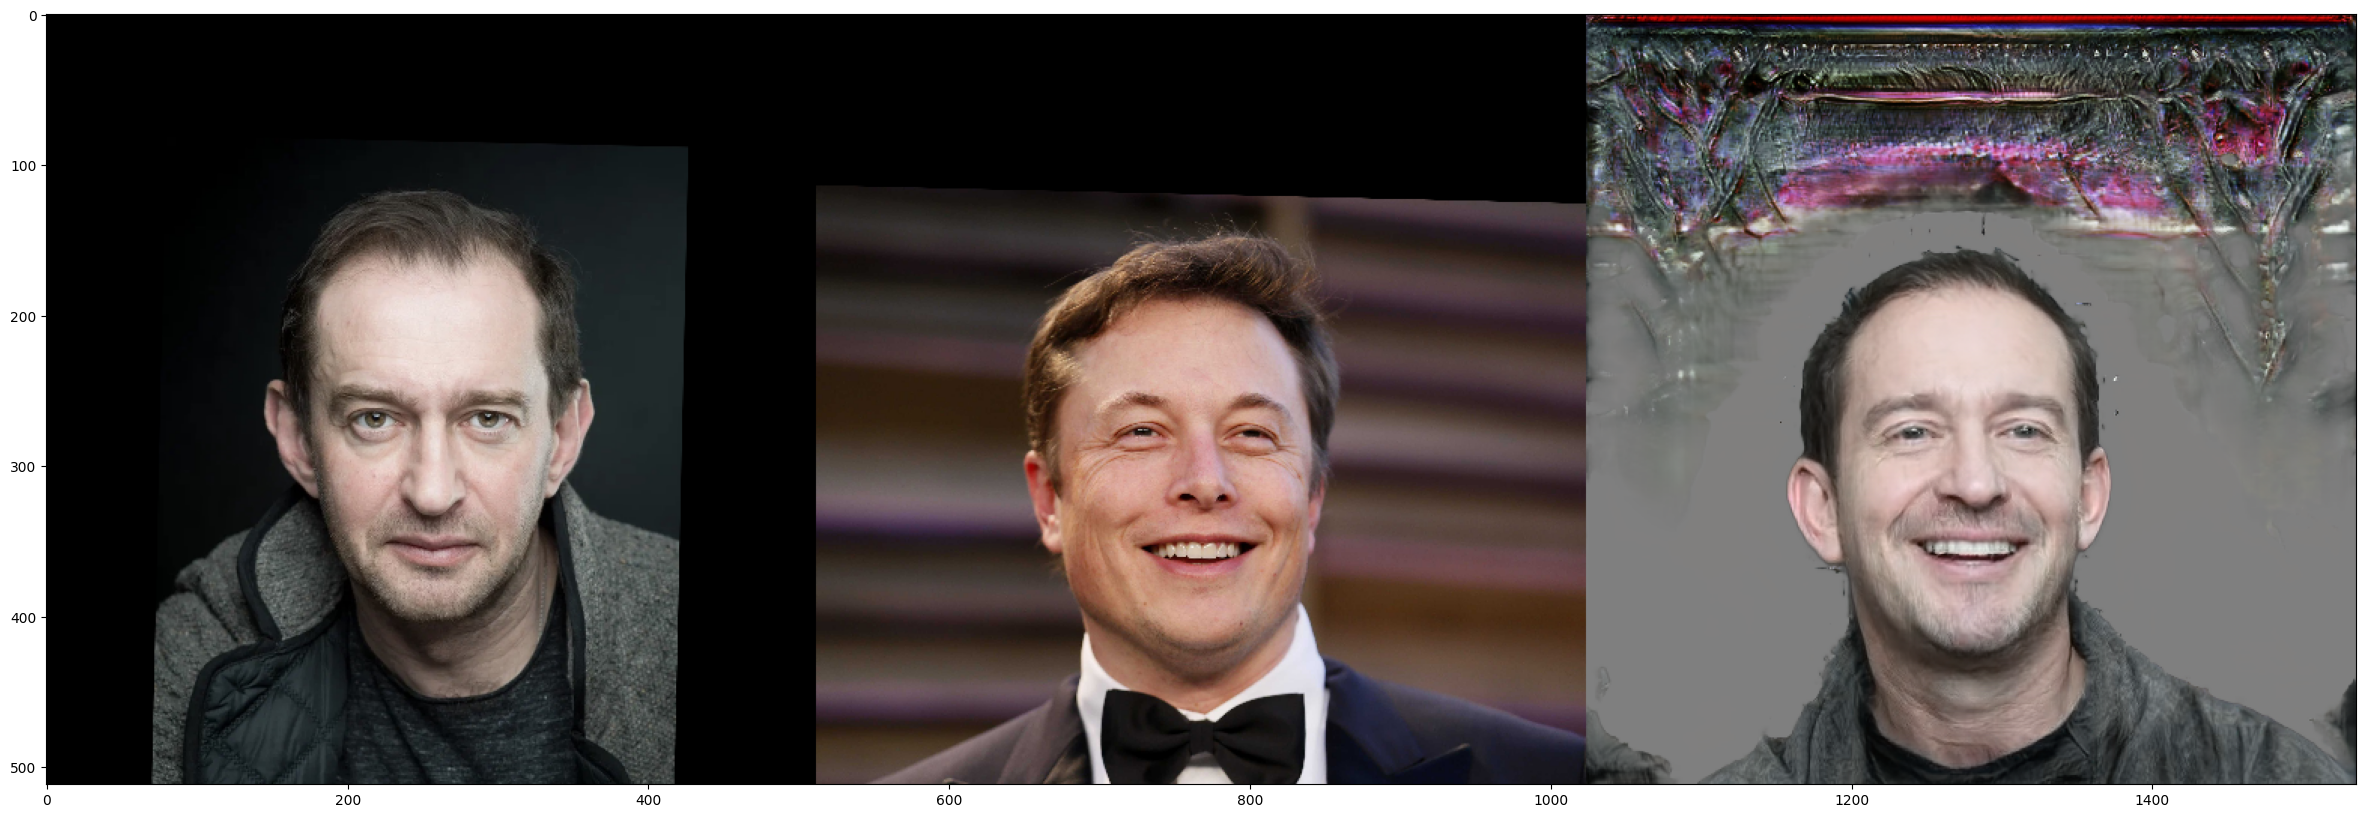

In [20]:
plt.figure(figsize=(30, 10))
np_output = np.uint8((output['fake_rgbs'][0].detach().cpu().numpy().transpose((1, 2, 0)) / 2 + 0.5) * 255)
output_for_video = np.concatenate([source, target, np_output], axis =1)
plt.imshow(output_for_video[:,:,::-1])

### Blender

In [21]:
providers = [
       ("CUDAExecutionProvider", {})
    ]
parsings_session = ort.InferenceSession('./weights/segformer_B5_ce.onnx', providers=providers)
input_name = parsings_session.get_inputs()[0].name
output_names = [output.name for output in parsings_session.get_outputs()]

mean = np.array([0.51315393, 0.48064056, 0.46301059])[None, :, None, None]
std = np.array([0.21438347, 0.20799829, 0.20304542])[None, :, None, None]


In [22]:
infer_parsing = lambda img: torch.tensor(
    parsings_session.run(output_names, {
        input_name: (((img[:, [2, 1, 0], ...] / 2 + 0.5).cpu().detach().numpy() - mean) / std).astype(np.float32)
    })[0],
    device='cuda',
    dtype=torch.float32
)

In [23]:
target_parsing = infer_parsing(norm_target)
pseudo_norm_target = calc_pseudo_target_bg(norm_target, target_parsing)
soft_mask = calc_mask(((output['fake_rgbs'] * output['fake_segm'])[0, [2, 1, 0], :, :] + 1) / 2)[None]
new_source = output['fake_rgbs'] * soft_mask[:, None, ...] + pseudo_norm_target * (1 - soft_mask[:, None, ...])

In [24]:
blender_input = {
        'face_source': new_source, # output['fake_rgbs']*output['fake_segm'] + norm_target*(1-output['fake_segm']),# face_source,
        'gray_source': rgb_to_grayscale(new_source[0][[2, 1, 0], ...]).unsqueeze(0),
        'face_target': norm_target,
        'mask_source': infer_parsing(output['fake_rgbs']*output['fake_segm']),
        'mask_target': target_parsing,
        'mask_source_noise': None,
        'mask_target_noise': None,
        'alpha_source': soft_mask
    }

In [25]:
output_b = blender(blender_input, inpainter=inpainter)

In [26]:
use_kandi = False

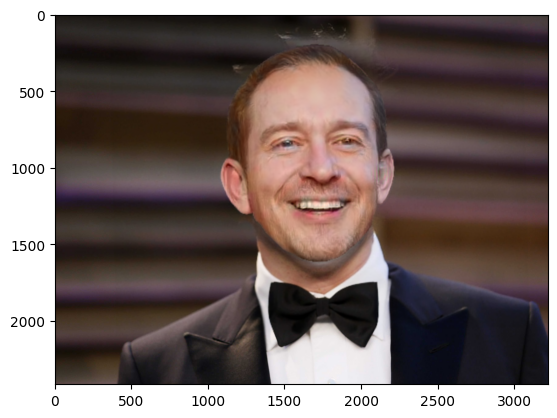

In [27]:
np_output = np.uint8((output_b['oup'][0].detach().cpu().numpy().transpose((1, 2, 0))[:,:,::-1] / 2 + 0.5)*255)
result = copy_head_back(np_output, full_frames[..., ::-1], M)
if use_kandi == True:
    result_inp = post_inpainting(result, output, full_frames, M, infer_parsing, pipe)
    plt.imshow(result_inp)
else:
    plt.imshow(result)